In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance
from math import dist
import itertools
import glob as glob
import os

In [277]:
from Bio import PDB

In [ ]:
### goal: compare changes in contact  in stability (due to mutation) vs. number of contacts for wt hphob residues


In [2]:
pwd

'/Volumes/GoogleDrive/My Drive/01_HEEH_design/code'

### load data

In [3]:
### 
def load_nmr_ensemble(nmr_design):
    '''return df with nmr ensemble atomic coordinates '''
    # load pdb file
    if nmr_design == '341':
        df_nmr=pd.read_csv('../data/pdbs/rd5_341_958_for_contact_analysis/heeh341_nmr_chains_aligned.pdb', delim_whitespace=True)
    
    if nmr_design == '341_dimer':
        subdf_chainA=pd.read_csv('../data/pdbs/rd5_341_958_for_contact_analysis/heeh341_nmr_chainA.pdb', 
                                 delim_whitespace=True)
        subdf_chainB=pd.read_csv('../data/pdbs/rd5_341_958_for_contact_analysis/heeh341_nmr_chainB.pdb', 
                                 delim_whitespace=True)
        df_nmr = pd.concat([subdf_chainA, subdf_chainB])
    if nmr_design == '958':
        df_nmr=pd.read_csv('../data/pdbs/rd5_341_958_for_contact_analysis/heeh958_nmr_final_aligned.pdb', 
                             delim_whitespace=True)

    df_nmr=df_nmr.dropna().reset_index()
    cols_int = ['level_1', 'level_5']
    cols_float = ['level_6', 'level_7', 'level_8', 'level_9', 'MODEL']
    for col in cols_int:
        df_nmr[col] = df_nmr[col].astype(int)
    for col in cols_float:
        df_nmr[col] = df_nmr[col].astype(float)
    return df_nmr


In [4]:
def process_nmr_pdb(df):
    ''' rename columns and convert data types to float, int, and keep only beta-carbon atomic coordinates'''

    df.columns=['atom', 'atom_num', 'atom_type', 'residue', 'chain', 
                      'res_pos', 'x', 'y', 'z', 'occupancy', 'b-factor', 'atom2']
    df['x'] = df['x'].astype(float)
    df['y'] = df['y'].astype(float)
    df['z'] = df['z'].astype(float)
    
    return df

In [5]:
def load_design_model(design):
    design=pd.read_csv('../data/pdbs/HEEH_TK_rd5_0'+design+'.pdb',  delim_whitespace=True)
    design=design.dropna()
    design.columns =['atom', 'atom_num', 'atom_type', 'residue', 'chain', 
                     'res_pos', 'x', 'y', 'z', 'occupancy', 'b-factor', 'atom2']
    design['atom_num'] = design['atom_num'].astype(int)
    design['res_pos'] = design['res_pos'].astype(int)
    design['x'] = design['x'].astype(float)
    design['y'] = design['y'].astype(float)
    design['z'] = design['z'].astype(float)
    return design
    

In [6]:
def get_bcarbon(df):
    df=df.query('atom_type=="CB"')
    return df

In [136]:
def res_type(df):
    ''' add column with 1-letter residue abbreviation'''
    aa_dict = {'GLY':'G',
               'ALA':'A',
              'VAL':'V',
              'LEU':'L',
              'ILE':'I',
              'PRO':'P',
              'MET':'M',
              'TRP':'W',
              'PHE':'F',
              'GLN':'Q',
              'ASN':'N',
              'TYR':'Y',
              'SER':'S',
              'THR':'T',
              'HIS':'H',
              'ARG':'R',
              'LYS':'K',
              'ASP':'D',
              'GLU':'E',}

    all_abbrev = []
    for res in list(df['residue']):
        abbrev = aa_dict[res]
        all_abbrev.append(abbrev)
    df['residue'] = all_abbrev
    return df

In [99]:
def average_nmr_df(df):
    ''' return df with the average coordinates for nmr data '''

    all_rows = []
    all_positions = np.unique(df['res_pos'])

    all_chains = np.unique(df['chain'])
    
    for chain in all_chains:
        subdf=df.query('chain==@chain')
        for position in all_positions:
            residues = subdf.query('res_pos==@position').reset_index() # get subset data
            x_avg = '%.3f'%residues['x'].mean() # get the average positions
            y_avg = '%.3f'%residues['y'].mean()
            z_avg = '%.3f'%residues['z'].mean()
            other_data = list(residues.iloc[0][['atom_num', 'atom_type', 'residue', 'chain', 'res_pos']])
            row = other_data + [x_avg, y_avg, z_avg]
            all_rows.append(row)
        avg_positions = pd.DataFrame(all_rows, columns = ['atom_num', 'atom_type', 'residue', 'chain', 
                                                          'res_pos', 'x', 'y', 'z'])

    return avg_positions

In [100]:
def pairwise_dist(df):
    ''' returns data on the euclidean distance for all possible position pairs of beta carbon positions bw chains '''

    pairwise = list(itertools.permutations(df.query('chain=="A"')['res_pos'], 2)) # get all pairwise position combinations
    all_chains = np.unique(df['chain'])
    newdf=pd.DataFrame()
    
    for chain in all_chains:
        subdf = df.query('chain==@chain')
        
        pairs = []
        pairwise_dist = []
        res1_type = []
        res2_type = []
          
        for pair in pairwise:
            first_pair = pair[0]
            second_pair = pair[1]

            res1 = subdf.query('res_pos==@first_pair')['residue'].tolist()[0]
            res2 = subdf.query('res_pos==@second_pair')['residue'].tolist()[0]
            # get coordinates
            first_x = float(subdf.query('res_pos==@first_pair')['x'])
            first_y = float(subdf.query('res_pos==@first_pair')['y'])
            first_z = float(subdf.query('res_pos==@first_pair')['z'])
            first_coord = np.array((first_x, first_y, first_z), dtype=float)
            second_x = float(subdf.query('res_pos==@second_pair')['x'])
            second_y = float(subdf.query('res_pos==@second_pair')['y'])
            second_z = float(subdf.query('res_pos==@second_pair')['z'])
            second_coord = np.array((second_x, second_y, second_z), dtype=float)
            # calculate distance
            distance = np.linalg.norm(first_coord-second_coord)
            # add results to lists
            pairs.append(pair)
            pairwise_dist.append(distance)
            res1_type.append(res1)
            res2_type.append(res2)
        
        tempdf = pd.DataFrame(pairs, columns=['pos1', 'pos2'])
        tempdf['pos_pair'] = pairs
        tempdf['dist'] = pairwise_dist
        tempdf['res1'] = res1_type
        tempdf['res2'] = res2_type
        tempdf['chain'] = chain
        newdf = pd.concat([newdf, tempdf])
    return newdf
    

In [324]:
def pairwise_dimer_dist(df):
    ''' returns data on the euclidean distance for all possible position pairs of beta carbon positions) '''

    pairwise = list(itertools.permutations(df.query('chain=="A"')['res_pos'], 2)) # get all pairwise position combinations
    newdf=pd.DataFrame()

   
    for pair in pairwise:
        
        pairs = []
        pairwise_dist = []
        res1_type = []
        res2_type = []
        chain1 = []
        chain2 = []
        
        # get pairs
        first_pair = pair[0]
        second_pair = pair[1]

        # get subdf for chains 
        subdf_A = df.query('chain=="A"')
        subdf_B = df.query('chain=="B"')

        # get residue 1 from chain A and residue 2 from B
        res1 = subdf_A.query('res_pos==@first_pair')['residue'].tolist()[0]
        res2 = subdf_B.query('res_pos==@second_pair')['residue'].tolist()[0]
        
        # get coordinates
        first_x = float(subdf_A.query('res_pos==@first_pair')['x'])
        first_y = float(subdf_A.query('res_pos==@first_pair')['y'])
        first_z = float(subdf_A.query('res_pos==@first_pair')['z'])
        first_coord = np.array((first_x, first_y, first_z), dtype=float)
        second_x = float(subdf_B.query('res_pos==@second_pair')['x'])
        second_y = float(subdf_B.query('res_pos==@second_pair')['y'])
        second_z = float(subdf_B.query('res_pos==@second_pair')['z'])
        second_coord = np.array((second_x, second_y, second_z), dtype=float)
        
        # calculate distance
        distance = np.linalg.norm(first_coord-second_coord)
        # add results to lists
        pairs.append(pair)
        chain1.append('A')
        chain2.append('B')
        pairwise_dist.append(distance)
        res1_type.append(res1)
        res2_type.append(res2)

        tempdf = pd.DataFrame(pairs, columns=['pos1', 'pos2'])
        tempdf['pos_pair'] = pairs
        tempdf['dist'] = pairwise_dist
        tempdf['res1'] = res1_type
        tempdf['res2'] = res2_type
        tempdf['chain1'] = chain1
        tempdf['chain2'] = chain2
        newdf = pd.concat([newdf, tempdf])
    
    return newdf

In [145]:
def final(nmr_design, design):
    df_nmr=load_nmr_ensemble(nmr_design) # load nmr pdb
    df_nmr=process_nmr_pdb(df=df_nmr) # convert nmr column data as int/float,
    df_design=load_design_model(design) # load design pdb
     
    df_nmr=get_bcarbon(df=df_nmr) # keep beta-carbon info for nmr
    df_design=get_bcarbon(df=df_design) # beta-carbon info for design model
    
    df_nmr=res_type(df=df_nmr) # add 1-abbrev residue
    df_design=res_type(df=df_design) # add 1-abbrev residue
        
    df_nmr_average=average_nmr_df(df=df_nmr)
   
    if nmr_design=='341_dimer':
        nmr_pairwise=pairwise_dimer_dist(df=df_nmr_average)
        return nmr_pairwise
    else:
        nmr_pairwise=pairwise_dist(df=df_nmr_average) # pairwise dists in nmr
    
    
    design_pairwise=pairwise_dist(df=df_design) # pairwise dist in design
    merge=pd.merge(left=nmr_pairwise, right=design_pairwise[['pos_pair','dist']], on='pos_pair', how='inner')
    merge.rename(columns={'dist_x':'dist_nmr', 'dist_y':'dist_design'}, inplace=True)
    return merge

In [146]:
df_341=final(nmr_design='341', design='341')

IndexError: single positional indexer is out-of-bounds

In [423]:
df_341

,pos1,pos2,pos_pair,dist_nmr,res1,res2,chain,dist_design
0,1,2,"(1, 2)",5.377941,ASP,LEU,A,6.090190
1,1,3,"(1, 3)",5.198130,ASP,GLU,A,7.215593
2,1,4,"(1, 4)",4.298590,ASP,GLU,A,4.452848
3,1,5,"(1, 5)",6.761312,ASP,LEU,A,5.804499
4,1,6,"(1, 6)",8.917424,ASP,GLU,A,9.468833
...,...,...,...,...,...,...,...,...
1635,43,38,"(43, 38)",10.815068,ILE,PHE,A,9.145934
1636,43,39,"(43, 39)",8.820275,ILE,LEU,A,5.527090
1637,43,40,"(43, 40)",9.774514,ILE,ARG,A,7.285665
1638,43,41,"(43, 41)",8.478401,ILE,ARG,A,7.827114


In [326]:
df_341_dimer=final(nmr_design='341_dimer', design='341')

In [312]:
df_958=final(nmr_design='958', design='958')

### more analysis


In [13]:
def keep_dist_close_contact(df):
    ''' distance < 8A'''
    nmr=df.query('dist_nmr < 8')
    design=df.query('dist_design <8')
    
    return nmr, design

In [14]:
def n_contacts(nmr, design):
    ''' quantify number of contacts gained and lost and add it to df '''
    
    chains=np.unique(nmr['chain'])
    newdf=pd.DataFrame()
    
    for chain in chains:
        sub_nmr=nmr.query('chain==@chain')
        sub_design=design.query('chain==@chain')
        
        nmr_contact_counts = sub_nmr['pos1']
        design_contact_counts = sub_design['pos1']
    
        # turn contacts freq into df
        df_nmr_contact_counts = nmr_contact_counts.value_counts().rename_axis('pos').reset_index(name='n_contacts_nmr') 
        df_design_contact_counts = design_contact_counts.value_counts().rename_axis('pos').reset_index(name='n_contacts_design') 

        # merge
        merge = pd.merge(left=df_nmr_contact_counts, right=df_design_contact_counts, on='pos', how='inner')
        # add difference in contacts
        merge['contact_diff'] = merge['n_contacts_nmr']-merge['n_contacts_design']
        merge['chain']=chain
        newdf=pd.concat([newdf, merge])
    return newdf



In [15]:
def final2(df, nmr_design):
    ''' returns df with N-contacts '''
    if nmr_design=='341_dimer':
        df=df.query('dist < 8')
        contact_counts=df['pos1']
        df_contact_counts=contact_counts.value_counts().rename_axis('pos').reset_index(name='n_contacts')
        return df_contact_counts
    else:
        nmr, design = keep_dist_close_contact(df) # keep pos-pairs whose dist < 8A
        contacts_df = n_contacts(nmr=nmr, design=design)
        return contacts_df
   # return merge


In [369]:
contacts_341 = final2(df=df_341, nmr_design='341')

### make plots

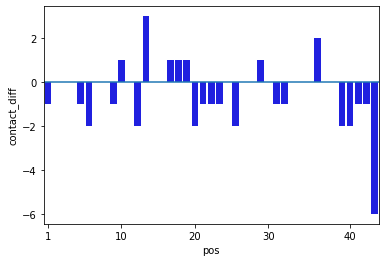

In [422]:
fig, ax = plt.subplots()
sns.barplot(x='pos', y='contact_diff', data=contacts_341, color='blue')
ax.set_xticks((0, 9, 18, 27, 37))
plt.axhline(y=0)
#plt.savefig('../figures/heeh341_contacts.svg')

In [350]:
dist_341dimer = final2(df=df_341_dimer, nmr_design='341_dimer')

### make plot of dimer contacts

In [416]:
positions = list(np.arange(1,44))
n_contacts = [ 0 for i in range(1,44)]

pos_contact_dict = dict(zip(positions, n_contacts))

In [418]:

for pos in np.unique(dist_341dimer['pos']):
    pos_contact_dict[pos] =int(dist_341dimer.query('pos==@pos')['n_contacts'])


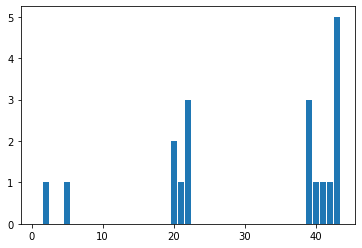

In [421]:
plt.bar(list(pos_contact_dict.keys()), list(pos_contact_dict.values()))
plt.savefig('../figures/heeh341dimer_contacts.svg')

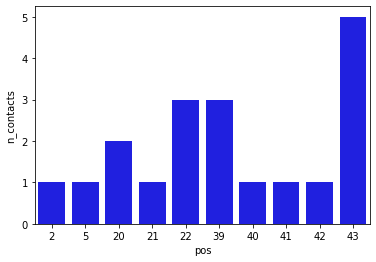

In [377]:
fig, ax = plt.subplots()
sns.barplot(x='pos', y='n_contacts', data=dist_341dimer, color='blue')
#ax.set_xticks((0, 4, 9, 14, 18, 22, 26, 30, 34, 38, 42))
#plt.axhline(y=0)
#plt.savefig('../figures/heeh341_dimercontacts.svg')

### analysis chain A + chain B

In [147]:
def average_chains(df):
    ''' return df with the average coordinates for nmr data '''
    
    all_positions = np.unique(df['res_pos'])
    all_chains = np.unique(df['chain'])
    
    newdf=pd.DataFrame()
    
    for chain in all_chains:
        subdf=df.query('chain==@chain')
        all_rows = []
        for position in all_positions:
            residues = subdf.query('res_pos==@position').reset_index() # get subset data
            x_avg = '%.3f'%residues['x'].mean() # get the average positions
            y_avg = '%.3f'%residues['y'].mean()
            z_avg = '%.3f'%residues['z'].mean()
            other_data = list(residues.iloc[0][['atom_num', 'atom_type', 'residue', 'chain', 'res_pos']])
            row = other_data + [x_avg, y_avg, z_avg]
            all_rows.append(row)
        avg_positions = pd.DataFrame(all_rows, columns = ['atom_num', 'atom_type', 'residue', 'chain', 
                                                          'res_pos', 'x', 'y', 'z'])

        newdf=pd.concat([newdf, avg_positions])
        
    return newdf

In [148]:
def pairwise_within_chains(df):
    ''' returns data on the euclidean distance for all possible position pairs of beta carbon positions bw chains '''

    pairwise = list(itertools.permutations(df.query('chain=="A"')['res_pos'], 2)) # get all pairwise position combinations
    #all_chains = np.unique(df['chain'])
    newdf=pd.DataFrame()
    
    for chain in ['A', 'B']:
        subdf = df.query('chain==@chain')

        pairs = []
        pairwise_dist = []
        res1_type = []
        res2_type = []
        
        for pair in pairwise:
            first_pair = pair[0]
            second_pair = pair[1]
            
            res1 = subdf.query('res_pos==@first_pair')['residue'].tolist()[0]
            res2 = subdf.query('res_pos==@second_pair')['residue'].tolist()[0]
  
            ### get coordinates
            first_x = float(subdf.query('res_pos==@first_pair')['x'])
            first_y = float(subdf.query('res_pos==@first_pair')['y'])
            first_z = float(subdf.query('res_pos==@first_pair')['z'])
            first_coord = np.array((first_x, first_y, first_z), dtype=float)
            
            second_x = float(subdf.query('res_pos==@second_pair')['x'])
            second_y = float(subdf.query('res_pos==@second_pair')['y'])
            second_z = float(subdf.query('res_pos==@second_pair')['z'])
            second_coord = np.array((second_x, second_y, second_z), dtype=float)
            
            ### calculate distance
            distance = np.linalg.norm(first_coord-second_coord)
            # add results to lists
            pairs.append(pair)
            pairwise_dist.append(distance)
            res1_type.append(res1)
            res2_type.append(res2)
        
        tempdf = pd.DataFrame(pairs, columns=['pos1', 'pos2'])
        tempdf['pos_pair'] = pairs
        tempdf['dist'] = pairwise_dist
        tempdf['res1'] = res1_type
        tempdf['res2'] = res2_type
        tempdf['chain1'] = chain
        tempdf['chain2'] = chain
        newdf = pd.concat([newdf, tempdf])
    return newdf
    

In [217]:
def pairwise_bw_chains(df):
    ''' returns data on the euclidean distance for all possible position pairs of beta carbon positions 
        within bw chains A-B  '''

    pairwise = list(itertools.permutations(df.query('chain=="A"')['res_pos'], 2)) # get all pairwise position combinations
    newdf=pd.DataFrame()


    # get subdf for chains 
    subdf_A = df.query('chain=="A"')
    subdf_B = df.query('chain=="B"')

    for pair in pairwise:
        
        pairs = []
        pairwise_dist = []
        res1_type = []
        res2_type = []
        chain1 = []
        chain2 = []
        
        # get pairs
        first_pair = pair[0]
        second_pair = pair[1]

        # get residue 1 from chain A and residue 2 from B
        res1 = subdf_A.query('res_pos==@first_pair')['residue'].tolist()[0]
        res2 = subdf_B.query('res_pos==@second_pair')['residue'].tolist()[0]
        
        # get coordinates
        first_x = float(subdf_A.query('res_pos==@first_pair')['x'])
        first_y = float(subdf_A.query('res_pos==@first_pair')['y'])
        first_z = float(subdf_A.query('res_pos==@first_pair')['z'])
        first_coord = np.array((first_x, first_y, first_z), dtype=float)
        second_x = float(subdf_B.query('res_pos==@second_pair')['x'])
        second_y = float(subdf_B.query('res_pos==@second_pair')['y'])
        second_z = float(subdf_B.query('res_pos==@second_pair')['z'])
        second_coord = np.array((second_x, second_y, second_z), dtype=float)
        
        # calculate distance
        distance = np.linalg.norm(first_coord-second_coord)
        # add results to lists
        pairs.append(pair)
        chain1.append('A')
        chain2.append('B')
        pairwise_dist.append(distance)
        res1_type.append(res1)
        res2_type.append(res2)

        tempdf = pd.DataFrame(pairs, columns=['pos1', 'pos2'])
        tempdf['pos_pair'] = pairs
        tempdf['dist'] = pairwise_dist
        tempdf['res1'] = res1_type
        tempdf['res2'] = res2_type
        tempdf['chain1'] = chain1
        tempdf['chain2'] = chain2
        newdf = pd.concat([newdf, tempdf])
    
    return newdf

In [219]:
def final3(nmr_design, design):
    df_nmr=load_nmr_ensemble(nmr_design) # load nmr pdb
    df_nmr=process_nmr_pdb(df=df_nmr) # convert nmr column data as int/float,
    df_design=load_design_model(design) # load design pdb
     
    df_nmr=get_bcarbon(df=df_nmr) # keep beta-carbon info for nmr
    df_design=get_bcarbon(df=df_design) # beta-carbon info for design model
    
    df_nmr=res_type(df=df_nmr) # add 1-abbrev residue
    df_design=res_type(df=df_design) # add 1-abbrev residue
    
    df_nmr_average=average_chains(df=df_nmr)# make average nmr structure for chain A and chain B
    
    ### pairwise dist
    design_dist=pairwise_dist(df=df_design) # pairwise dist in design

    within_chains_dist=pairwise_within_chains(df=df_nmr_average) # pairwise dist within chain A, chain B
    bw_chains_dist=pairwise_bw_chains(df=df_nmr_average) # pairwise dist bw chain A and chain B
    #merge_chain=pd.concat([within_chains_dist, bw_chains_dist])
    
    
    return within_chains_dist, bw_chains_dist, design_dist
    

In [220]:
dist341_win_chain, dist341_bw_chain, dist341=final3(nmr_design='341_dimer', design='341')

In [272]:
#### merge chain data
dist341_chain=pd.concat([dist341_win_chain.query('chain1=="A"') ,dist341_bw_chain] )

In [273]:
len(dist341_win_chain), len(dist341_bw_chain), len(dist341_chain)

(3280, 1640, 3280)

In [300]:
dist341.query('pos1==22')

,pos1,pos2,pos_pair,dist,res1,res2,chain
819,22,21,"(22, 21)",4.868826,L,I,A
820,22,24,"(22, 24)",5.612487,L,I,A
835,22,39,"(22, 39)",7.867833,L,L,A
838,22,42,"(22, 42)",7.136561,L,F,A


In [299]:
dist341_chain.query('pos1==22')

,pos1,pos2,pos_pair,dist,res1,res2,chain1,chain2
819,22,21,"(22, 21)",5.056653,L,I,A,A
820,22,24,"(22, 24)",6.436853,L,I,A,A
835,22,39,"(22, 39)",7.890458,L,L,A,A
0,22,5,"(22, 5)",6.031399,L,L,A,B
0,22,21,"(22, 21)",4.433699,L,I,A,B
0,22,39,"(22, 39)",5.516515,L,L,A,B


In [277]:
### keep data dist < 8A
dist341_chain = dist341_chain.query('dist <8')
dist341 = dist341.query('dist < 8')

In [283]:
### contacts for deisgn
design_contact_counts = dist341['pos1']
df_design_contact_counts=design_contact_counts.value_counts().rename_axis('pos').reset_index(name='n_contacts_design') 


In [284]:
### contacts in nmr (chain A with itself and with chain B)
chain_counts=dist341_chain['pos1']
df_chainA_contact_counts=chain_counts.value_counts().rename_axis('pos').reset_index(name='n_contacts_chainA') 

In [288]:
### merge contacts df
contacts_merge = pd.merge(left=df_design_contact_counts, right=df_chainA_contact_counts, on='pos', how='inner')

In [289]:
### add contact diff columnsa
contacts_merge['contacts_diff'] = contacts_merge['n_contacts_chainA']-contacts_merge['n_contacts_design']

In [295]:
contacts_merge.sort_values('pos', ascending=True)

,pos,n_contacts_design,n_contacts_chainA,contacts_diff
35,1,5,4,-1
21,2,8,9,1
34,3,6,6,0
27,4,7,7,0
8,5,11,11,0
9,6,11,9,-2
23,7,8,8,0
16,8,9,9,0
1,9,14,13,-1
15,10,9,10,1


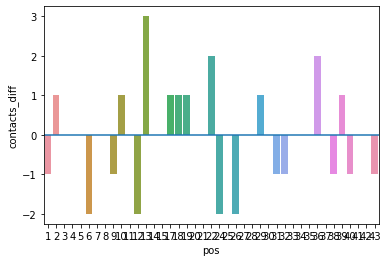

In [293]:
fig, ax = plt.subplots()
sns.barplot(x='pos', y='contacts_diff', data=contacts_merge)



#sns.barplot(x='pos', y='contact_diff', data=contacts_341, color='blue')
#ax.set_xticks((0, 9, 18, 27, 37))
plt.axhline(y=0)
plt.savefig('../figures/heeh341_contacts2.svg')

In [177]:
z

,pos1,pos2,pos_pair,dist_nmr,res1,res2,chain1,chain2,dist_design
0,1,2,"(1, 2)",5.432217,D,L,A,A,6.090190
1,1,2,"(1, 2)",5.328186,D,L,B,B,6.090190
2,1,3,"(1, 3)",5.211000,D,E,A,A,7.215593
3,1,3,"(1, 3)",5.192046,D,E,B,B,7.215593
4,1,4,"(1, 4)",4.196139,D,E,A,A,4.452848
...,...,...,...,...,...,...,...,...,...
629,41,43,"(41, 43)",7.132260,R,I,A,B,7.827114
630,43,2,"(43, 2)",7.614813,I,L,A,B,4.301531
631,43,39,"(43, 39)",7.159004,I,L,A,B,5.527090
632,43,40,"(43, 40)",4.969529,I,R,A,B,7.285665


In [ ]:
chain, design = final4(chain=dist341chain, design=dist341)

In [156]:
dist341chainA = dist341chain.query('chain1=="A" & chain2=="A"')

In [162]:
dist341chainA_design = pd.merge(left=dist341chainA, right=dist341[['pos_pair', 'dist']], on='pos_pair', how='inner')


In [165]:
dist341chainA_design['dist_diff']= dist341chainA_design['dist_design']-dist341chainA_design['nmr_design']

In [166]:
dist341chainA_design

,pos1,pos2,pos_pair,dist_design,res1,res2,chain1,chain2,nmr_design,dist_diff
0,1,2,"(1, 2)",5.432217,D,L,A,A,6.090190,-0.657974
1,1,3,"(1, 3)",5.211000,D,E,A,A,7.215593,-2.004593
2,1,4,"(1, 4)",4.196139,D,E,A,A,4.452848,-0.256709
3,1,5,"(1, 5)",6.760654,D,L,A,A,5.804499,0.956155
4,1,6,"(1, 6)",8.904233,D,E,A,A,9.468833,-0.564600
...,...,...,...,...,...,...,...,...,...,...
1635,43,38,"(43, 38)",10.768433,I,F,A,A,9.145934,1.622499
1636,43,39,"(43, 39)",8.956121,I,L,A,A,5.527090,3.429031
1637,43,40,"(43, 40)",9.906454,I,R,A,A,7.285665,2.620789
1638,43,41,"(43, 41)",8.644073,I,R,A,A,7.827114,0.816959


In [153]:
dist341

,pos1,pos2,pos_pair,dist,res1,res2,chain
0,1,2,"(1, 2)",6.090190,D,L,A
1,1,3,"(1, 3)",7.215593,D,E,A
2,1,4,"(1, 4)",4.452848,D,E,A
3,1,5,"(1, 5)",5.804499,D,L,A
4,1,6,"(1, 6)",9.468833,D,E,A
...,...,...,...,...,...,...,...
1635,43,38,"(43, 38)",9.145934,I,F,A
1636,43,39,"(43, 39)",5.527090,I,L,A
1637,43,40,"(43, 40)",7.285665,I,R,A
1638,43,41,"(43, 41)",7.827114,I,R,A


/Users/tek317/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='dist', ylabel='Density'>

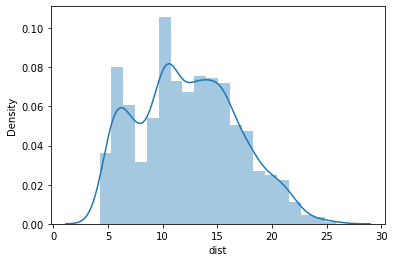

In [132]:
sns.distplot(dist341['dist'])

In [131]:
dist341

,pos1,pos2,pos_pair,dist,res1,res2,chain
0,1,2,"(1, 2)",6.090190,ASP,LEU,A
1,1,3,"(1, 3)",7.215593,ASP,GLU,A
2,1,4,"(1, 4)",4.452848,ASP,GLU,A
3,1,5,"(1, 5)",5.804499,ASP,LEU,A
4,1,6,"(1, 6)",9.468833,ASP,GLU,A
...,...,...,...,...,...,...,...
1635,43,38,"(43, 38)",9.145934,ILE,PHE,A
1636,43,39,"(43, 39)",5.527090,ILE,LEU,A
1637,43,40,"(43, 40)",7.285665,ILE,ARG,A
1638,43,41,"(43, 41)",7.827114,ILE,ARG,A


In [408]:
def final(design):
    list_pdb_filenames = subset_pdbs(design)
    wt_file = get_wt_filename(pdbs=list_pdb_filenames)
    bcarbon_coord = wt_bcarbon(pdb=wt_file)
    bcarbon_coord = res_type(df=bcarbon_coord)
    bcarbon_coord_hphob = keep_mut(df=bcarbon_coord)
    pairwise = pairwise_dist(df=bcarbon_coord_hphob, design=design)
    close_contacts_df = keep_dist_close_contact(df=pairwise)
    n_contacts_df = n_contacts(df=close_contacts_df)
    return n_contacts_df

### get df for all 6 designs with pairwise distances < 8A 


In [345]:
pairwise_df

,pos1,pos2,pos_pair,dist,res1,res2,design,n_contacts
0,2,5,"(2, 5)",5.669498,F,L,HEEH_TK_rd5_0018,3
1,2,6,"(2, 6)",6.716068,F,I,HEEH_TK_rd5_0018,3
2,2,43,"(2, 43)",6.211002,F,A,HEEH_TK_rd5_0018,3
3,5,2,"(5, 2)",5.669498,L,F,HEEH_TK_rd5_0018,4
4,5,6,"(5, 6)",5.431468,L,I,HEEH_TK_rd5_0018,4
...,...,...,...,...,...,...,...,...
79,39,36,"(39, 36)",5.681128,A,A,HEEH_TK_rd5_3711,6
80,39,38,"(39, 38)",5.190767,A,W,HEEH_TK_rd5_3711,6
81,39,42,"(39, 42)",6.517412,A,W,HEEH_TK_rd5_3711,6
82,42,38,"(42, 38)",6.569429,W,W,HEEH_TK_rd5_3711,2


### get dms stability score data

In [410]:
os.chdir('/Volumes/GoogleDrive/My Drive/01_HEEH_design/2022_HEEH_manuscript/data/stability_scores/')

In [348]:
pwd

'/Volumes/GoogleDrive/My Drive/01_HEEH_design/2022_HEEH_manuscript/data/stability_scores'

In [349]:
def get_dms_stability():
 
    dms = pd.read_csv('rd5_deep_mutational_scanning_stability_scores.csv')
    # add columns
    dms['design'] = [ name.split('.')[0] for name in dms['name']]
    dms['mutant'] = [ name.split('_')[-1] for name in dms['name']]
    dms['type'] = [ 'wt' if mut[-1]=='b' else 'mut' for mut in dms['mutant']]
    
    wt_df = dms.query('type=="wt"')
    wt_df.rename(columns={'stabilityscore':'wt_stabilityscore'}, inplace=True) # rename column
    mut_df = dms.query('type=="mut"')
    
    mut_df['pos'] = [ int(x[1:3]) if x[2] in '1234567890'  else int(x[1]) for x in mut_df['mutant']]
    
    return wt_df[['design', 'wt_stabilityscore']], mut_df[['design', 'mutant', 'pos', 'stabilityscore']]

In [350]:
def add_wt_stability(pairwise, wt_df):
    ''' add wt stability score to pairwise df'''
    merge = pd.merge(left=pairwise, right=wt_df, on='design', how='inner')
    return merge

In [351]:
def add_avg_mut_stability(mut_df):
    
    ''' from dms df, make newdf with pos and average mut stability score at each position '''
    
    positions = np.unique(mut_df['pos'])
    
    merge_df = pd.DataFrame() # this df will have design, pos, avg_mut_stability
    
    for design in ['HEEH_TK_rd5_0018', 'HEEH_TK_rd5_0341', 'HEEH_TK_rd5_0420', 'HEEH_TK_rd5_0614',
                   'HEEH_TK_rd5_0958', 'HEEH_TK_rd5_3711']:
    
        subset_df = mut_df.query('design==@design')  # subset df by design
        avg_stability_pos = {}
        for position in positions:
            pos_df = subset_df.query('pos==@position') # subset design df by res position
            avg_stability = np.mean(pos_df['stabilityscore']) # average mutant stabilityscore
            avg_stability_pos[position]=avg_stability # add avg mut stabilityscore to dict
        
        dict_df = pd.DataFrame(avg_stability_pos.items(), columns=['pos1', 'avg_mut_stability']) # convert dict to df
        dict_df['design'] = design # add design name as a column
        merge_df=pd.concat([merge_df, dict_df])
    
    return merge_df

In [352]:
def merge_pairwise_avg_mut(pairwise, avg_mut):
    
    newdf=pd.DataFrame()
    
    for design in ['HEEH_TK_rd5_0018', 'HEEH_TK_rd5_0341', 'HEEH_TK_rd5_0420', 'HEEH_TK_rd5_0614',
                   'HEEH_TK_rd5_0958', 'HEEH_TK_rd5_3711']: 
        sub_pairwise_df = pairwise.query('design==@design') # subset df by design
        sub_avgmut_df = avg_mut.query('design==@design') # subset avgmut df by design
        
        merge_subdf = pd.merge(left=sub_pairwise_df, right=sub_avgmut_df[['pos1','avg_mut_stability' ]], 
                         on='pos1', how='inner') # merge

        newdf=pd.concat([newdf, merge_subdf])
    newdf['change_avg_mut_stability'] = newdf['avg_mut_stability']-newdf['wt_stabilityscore']
    return newdf

In [411]:
def final():
    wt_df, mut_df = get_dms_stability()
    merge_pairwise_wt_df = add_wt_stability(pairwise=pairwise_df, wt_df=wt_df) # add wt
    
    avg_mut_stability = add_avg_mut_stability(mut_df=mut_df)
    
    merge_pairwise_wt_avgmut_df = merge_pairwise_avg_mut(pairwise=merge_pairwise_wt_df, avg_mut=avg_mut_stability)
    
    
    return merge_pairwise_wt_avgmut_df

In [412]:
df=final()

/Users/tek317/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/var/folders/35/r7mlztxx5bj0x1y0f49pww80cq0ykg/T/ipykernel_11069/3648236755.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mut_df['pos'] = [ int(x[1:3]) if x[2] in '1234567890'  else int(x[1]) for x in mut_df['mutant']]


In [413]:
res_types = []

for res in df['res1']:
    if res =='A':
        res_types.append('A')
    if res in 'LIV':
        res_types.append('LIV')
    if res in 'FW':
        res_types.append('FW')
df['res_type'] = res_types

In [414]:
df.head()

,pos1,pos2,pos_pair,dist,res1,res2,design,n_contacts,wt_stabilityscore,avg_mut_stability,change_avg_mut_stability,res_type
0,2,5,"(2, 5)",5.669498,F,L,HEEH_TK_rd5_0018,4,2.857318,2.561744,-0.295575,FW
1,2,6,"(2, 6)",6.716068,F,I,HEEH_TK_rd5_0018,4,2.857318,2.561744,-0.295575,FW
2,2,39,"(2, 39)",7.663924,F,L,HEEH_TK_rd5_0018,4,2.857318,2.561744,-0.295575,FW
3,2,43,"(2, 43)",6.211002,F,A,HEEH_TK_rd5_0018,4,2.857318,2.561744,-0.295575,FW
4,5,2,"(5, 2)",5.669498,L,F,HEEH_TK_rd5_0018,4,2.857318,2.024433,-0.832885,LIV


/Users/tek317/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='res1', ylabel='count'>

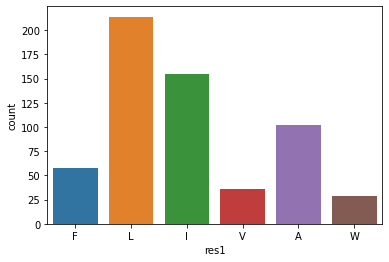

In [415]:
sns.countplot(df['res1'])

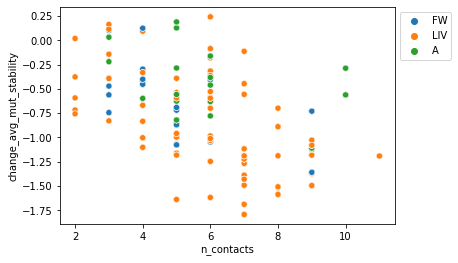

In [416]:
sns.scatterplot(x='n_contacts', y='change_avg_mut_stability', data=df, hue='res_type')
plt.legend(bbox_to_anchor=(1,1), loc="upper left") 

In [382]:
df.query('n_contacts==10')

,pos1,pos2,pos_pair,dist,res1,res2,design,n_contacts,wt_stabilityscore,avg_mut_stability,change_avg_mut_stability,res_type
18,9,5,"(9, 5)",6.537412,A,L,HEEH_TK_rd5_0420,10,2.811399,2.524969,-0.286429,A
19,9,6,"(9, 6)",5.661904,A,L,HEEH_TK_rd5_0420,10,2.811399,2.524969,-0.286429,A
20,9,8,"(9, 8)",5.281181,A,L,HEEH_TK_rd5_0420,10,2.811399,2.524969,-0.286429,A
21,9,12,"(9, 12)",5.690845,A,A,HEEH_TK_rd5_0420,10,2.811399,2.524969,-0.286429,A
22,9,13,"(9, 13)",6.331600,A,L,HEEH_TK_rd5_0420,10,2.811399,2.524969,-0.286429,A
23,9,19,"(9, 19)",5.641230,A,I,HEEH_TK_rd5_0420,10,2.811399,2.524969,-0.286429,A
24,9,21,"(9, 21)",6.126011,A,I,HEEH_TK_rd5_0420,10,2.811399,2.524969,-0.286429,A
25,9,26,"(9, 26)",4.598077,A,I,HEEH_TK_rd5_0420,10,2.811399,2.524969,-0.286429,A
26,9,32,"(9, 32)",5.367201,A,L,HEEH_TK_rd5_0420,10,2.811399,2.524969,-0.286429,A
27,9,35,"(9, 35)",5.971336,A,F,HEEH_TK_rd5_0420,10,2.811399,2.524969,-0.286429,A


In [ ]:
df

/Users/tek317/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='res1', ylabel='count'>

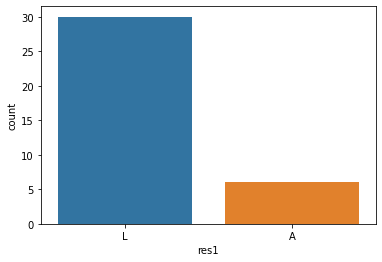

In [381]:
sns.countplot(df.query('pos1==39')['res1'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


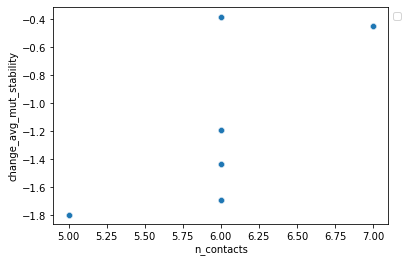

In [379]:
sns.scatterplot(x='n_contacts', y='change_avg_mut_stability', data=df.query('pos1==39'))
                                                                      
                                                                      #hue='change_avg_mut_stability', s=100)
plt.legend(bbox_to_anchor=(1,1), loc="upper left") 

In [392]:
df

,pos1,pos2,pos_pair,dist,res1,res2,design,n_contacts,wt_stabilityscore,avg_mut_stability,change_avg_mut_stability,res_type
0,2,5,"(2, 5)",5.669498,F,L,HEEH_TK_rd5_0018,3,2.857318,2.561744,-0.295575,FW
1,2,6,"(2, 6)",6.716068,F,I,HEEH_TK_rd5_0018,3,2.857318,2.561744,-0.295575,FW
2,2,43,"(2, 43)",6.211002,F,A,HEEH_TK_rd5_0018,3,2.857318,2.561744,-0.295575,FW
3,5,2,"(5, 2)",5.669498,L,F,HEEH_TK_rd5_0018,4,2.857318,2.024433,-0.832885,LIV
4,5,6,"(5, 6)",5.431468,L,I,HEEH_TK_rd5_0018,4,2.857318,2.024433,-0.832885,LIV
...,...,...,...,...,...,...,...,...,...,...,...,...
79,39,36,"(39, 36)",5.681128,A,A,HEEH_TK_rd5_3711,6,2.256550,1.874683,-0.381866,A
80,39,38,"(39, 38)",5.190767,A,W,HEEH_TK_rd5_3711,6,2.256550,1.874683,-0.381866,A
81,39,42,"(39, 42)",6.517412,A,W,HEEH_TK_rd5_3711,6,2.256550,1.874683,-0.381866,A
82,42,38,"(42, 38)",6.569429,W,W,HEEH_TK_rd5_3711,2,2.256550,1.786035,-0.470515,FW


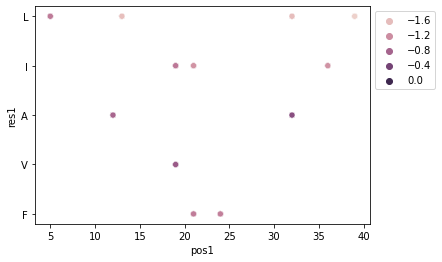

In [395]:
sns.scatterplot(x='pos1', y='res1', data=df.query('n_contacts==5'), hue='change_avg_mut_stability')
plt.legend(bbox_to_anchor=(1,1), loc="upper left") 

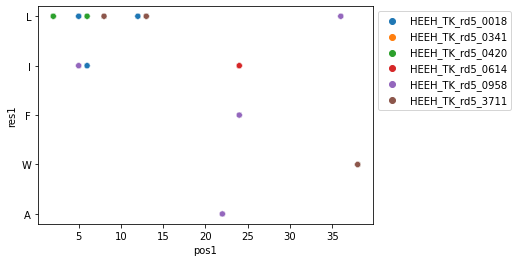

In [399]:
sns.scatterplot(x='pos1', y='res1', data=df.query('n_contacts==4'), hue='design')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")

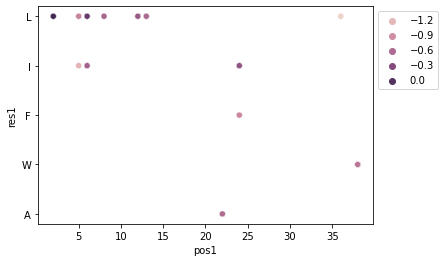

In [394]:
sns.scatterplot(x='pos1', y='res1', data=df.query('n_contacts==4'), hue='change_avg_mut_stability')
plt.legend(bbox_to_anchor=(1,1), loc="upper left") 

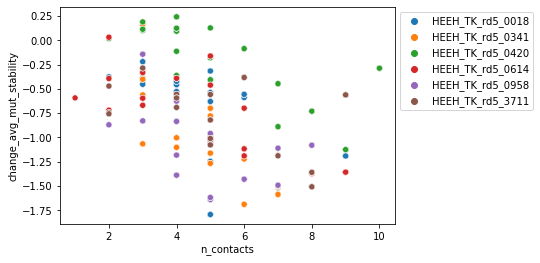

In [386]:
sns.scatterplot(x='n_contacts', y='change_avg_mut_stability', data=df, hue='design')
plt.legend(bbox_to_anchor=(1,1), loc="upper left") 

In [420]:
len(df)

594

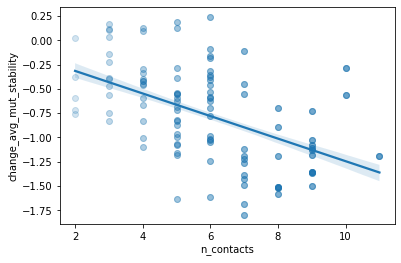

In [419]:
sns.regplot(x='n_contacts', y='change_avg_mut_stability', data=df, scatter_kws={'alpha':0.1})
plt.savefig('n_contacts.svg')

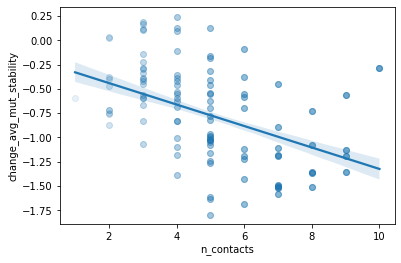

In [403]:
sns.regplot(x='n_contacts', y='change_avg_mut_stability', data=df, scatter_kws={'alpha':0.1})
plt.savefig('n_contacts.svg')

In [404]:
pwd

'/Volumes/GoogleDrive/My Drive/01_HEEH_design/2022_HEEH_manuscript/data/stability_scores'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


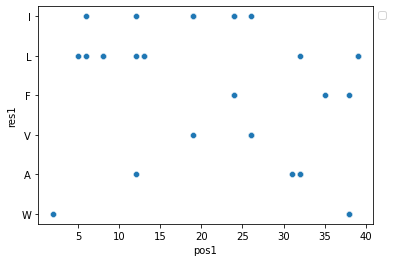

In [230]:
sns.scatterplot(x='pos1', y='res1', data=df.query('n_contacts==2'))#, hue='design')
plt.legend(bbox_to_anchor=(1,1), loc="upper left") 

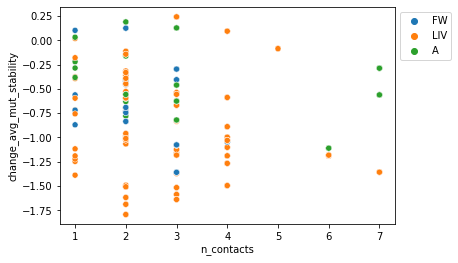

In [242]:
sns.scatterplot(x='n_contacts', y='change_avg_mut_stability', data=df, hue='res_type')
plt.legend(bbox_to_anchor=(1,1), loc="upper left") 

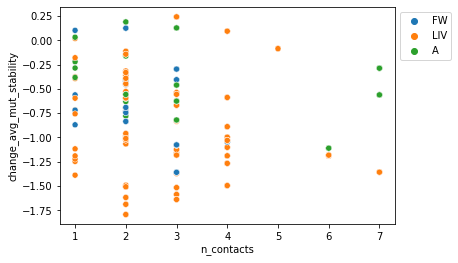

In [231]:
sns.scatterplot(x='n_contacts', y='change_avg_mut_stability', data=df, hue='res_type')
plt.legend(bbox_to_anchor=(1,1), loc="upper left") 

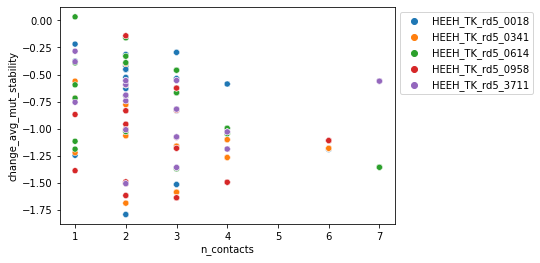

In [232]:
sns.scatterplot(x='n_contacts', y='change_avg_mut_stability', data=df.query('design!="HEEH_TK_rd5_0420"'), hue='design')
plt.legend(bbox_to_anchor=(1,1), loc="upper left") 

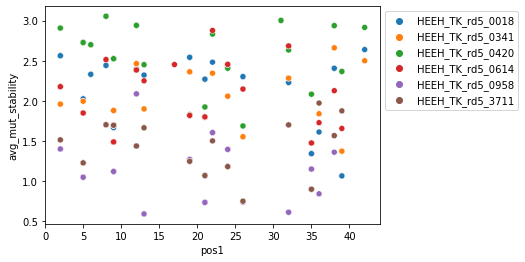

In [238]:
#plt.figure(figsize=(15,5))
sns.scatterplot(x='pos1', y='avg_mut_stability', data=df, hue='design')
plt.legend(bbox_to_anchor=(1,1), loc="upper left") 

In [125]:
np.unique(df['stabilityscore'])

array([2.22889504, 2.25654955, 2.81139854, 2.84452684, 2.85731812,
       3.0604346 ])

/Users/tek317/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='res1', ylabel='count'>

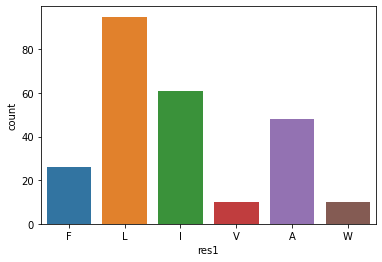

In [237]:
sns.countplot(df['res1'])

<AxesSubplot:xlabel='pos', ylabel='res1'>

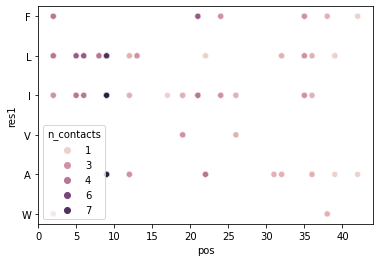

In [113]:
sns.scatterplot(x='pos', y='res1', data=a, hue='n_contacts')

<AxesSubplot:xlabel='pos', ylabel='res1'>

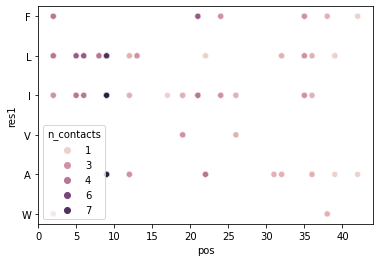

In [106]:
sns.scatterplot(x='pos', y='res1', data=a, hue='n_contacts')

<AxesSubplot:xlabel='res1', ylabel='change_avg_mut_stability'>

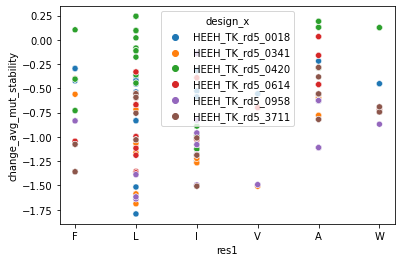

In [114]:
sns.scatterplot(x='res1', y='change_avg_mut_stability', data=a, hue='design_x')

<AxesSubplot:xlabel='res1', ylabel='change_avg_mut_stability'>

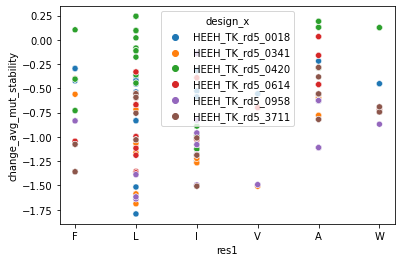

In [104]:
sns.scatterplot(x='res1', y='change_avg_mut_stability', data=a, hue='design_x')

<AxesSubplot:xlabel='n_contacts', ylabel='change_avg_mut_stability'>

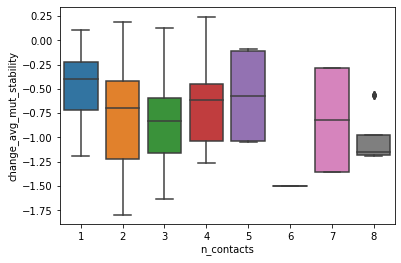

In [103]:
sns.boxplot(x='n_contacts', y='change_avg_mut_stability', data=a)#, hue='res1')

<AxesSubplot:xlabel='n_contacts', ylabel='change_avg_mut_stability'>

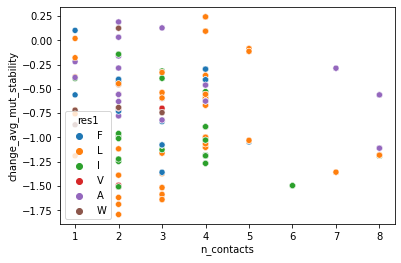

In [115]:
sns.scatterplot(x='n_contacts', y='change_avg_mut_stability', data=a, hue='res1')

<AxesSubplot:xlabel='n_contacts', ylabel='change_avg_mut_stability'>

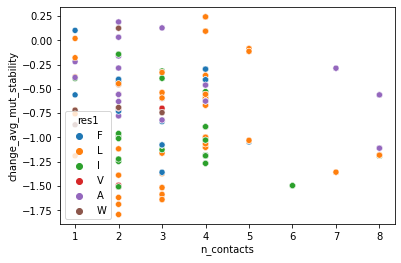

In [100]:
sns.scatterplot(x='n_contacts', y='change_avg_mut_stability', data=a, hue='res1')

In [52]:
a


,pos1,pos2,pos_pair,dist,res1,res2,design,n_contacts,stabilityscore,pos,avg_mut_stability,change_avg_stability
0,2,5,"(2, 5)",5.669498,F,L,HEEH_TK_rd5_0018,4,2.857318,2,2.561744,-0.295575
1,2,5,"(2, 5)",5.669498,F,L,HEEH_TK_rd5_0018,4,2.857318,2,1.959121,-0.898197
2,2,5,"(2, 5)",5.669498,F,L,HEEH_TK_rd5_0018,4,2.857318,2,2.906360,0.049042
3,2,5,"(2, 5)",5.669498,F,L,HEEH_TK_rd5_0018,4,2.857318,2,2.176332,-0.680986
4,2,5,"(2, 5)",5.669498,F,L,HEEH_TK_rd5_0018,4,2.857318,2,1.400089,-1.457229
...,...,...,...,...,...,...,...,...,...,...,...,...
283,39,42,"(39, 42)",6.517412,A,W,HEEH_TK_rd5_3711,1,2.256550,39,1.372280,-0.884270
284,39,42,"(39, 42)",6.517412,A,W,HEEH_TK_rd5_3711,1,2.256550,39,2.365575,0.109025
285,39,42,"(39, 42)",6.517412,A,W,HEEH_TK_rd5_3711,1,2.256550,39,1.655309,-0.601240
286,39,42,"(39, 42)",6.517412,A,W,HEEH_TK_rd5_3711,1,2.256550,39,0.799681,-1.456869


/Users/tek317/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='dist', ylabel='Density'>

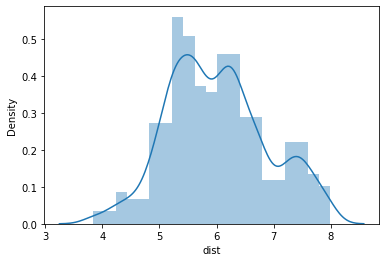

In [163]:
sns.distplot(a['dist'])

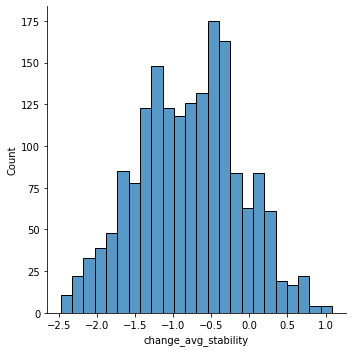

In [146]:
sns.displot(a['change_avg_stability'])

In [136]:
a

,pos1,pos2,pos_pair,dist,res1,res2,design,stabilityscore
0,2,5,"(2, 5)",5.669498,F,L,HEEH_TK_rd5_0018,2.857318
1,2,6,"(2, 6)",6.716068,F,I,HEEH_TK_rd5_0018,2.857318
2,2,39,"(2, 39)",7.663924,F,L,HEEH_TK_rd5_0018,2.857318
3,2,43,"(2, 43)",6.211002,F,A,HEEH_TK_rd5_0018,2.857318
4,5,6,"(5, 6)",5.431468,L,I,HEEH_TK_rd5_0018,2.857318
...,...,...,...,...,...,...,...,...
292,36,38,"(36, 38)",7.216232,A,W,HEEH_TK_rd5_3711,2.256550
293,36,39,"(36, 39)",5.681128,A,A,HEEH_TK_rd5_3711,2.256550
294,38,39,"(38, 39)",5.190767,W,A,HEEH_TK_rd5_3711,2.256550
295,38,42,"(38, 42)",6.569429,W,W,HEEH_TK_rd5_3711,2.256550


In [123]:
b.query('pos==2')

,pos,avg_mut_stability,design
1,2,2.561744,HEEH_TK_rd5_0018
1,2,1.959121,HEEH_TK_rd5_0341
1,2,2.906360,HEEH_TK_rd5_0420
1,2,2.176332,HEEH_TK_rd5_0614
1,2,1.400089,HEEH_TK_rd5_0958
1,2,1.513207,HEEH_TK_rd5_3711


### quantify mutants distances

In [219]:

#def dict_mutants_contacts(pdb_list, dist_wt):
#    mutants = {} # keys (mutant) : values ()

    #for pdb in dms_0018_pdbs[:2]:
#    for pdb in pdb_list:


#        df = load_dms(pdb = pdb) # returns beta-carbon atomic coordinates
#        df = res_type(df = df) # add residue abbreviation 
#        df = pairwise_dist(df = df) # get pairwise distances 
#        df = pd.merge(right=df, left=dist_wt[['pos_pair', 'dist']],
 #                     on='pos_pair', how='inner') # add pairwise dist from wt design

        df = sorted(df.query('(dist_x < 8 & dist_y > 8) & abs(pos1-pos2)>4')['pos1']) # quantify contacts
        mutant = pdb.split('_')[4].split('.')[0]  # get mutant
        mutants[mutant] = df # add mutant and contacts to dict
        print(mutant, df) # output
    return mutants
        
     

In [239]:
contacts_0018 = dict_mutants_contacts(pdb_list=hphob_0018, dist_wt=pairwise_wt_0018)

F24S [9, 9, 13, 14, 24, 24]
L39Y [2, 2, 6, 9, 10]
L13H [13, 14, 20]
A32V [13, 14, 20]
I19Y [13, 14, 19, 20]
L5D [14, 20]
I21H [9, 13, 14, 20]
I21N [9, 13, 14, 19, 20, 21, 21]
I21R [9, 9, 13, 14, 19, 20, 21, 21]
L35V [14]
I6G [10, 14, 20, 24]
A32H [9, 13, 14, 19, 19]
I9A []
A42E [13, 14]
I9Q [2, 9, 9, 13, 19, 24]
L39F [6, 9, 10]
A42L [13, 14]
V26L [13, 14]
L8M [13, 14, 20]
L39W [2, 2, 6, 9, 10]
L22S [13, 14, 20, 24]
I21W [10, 14]
I19T [9, 9, 13, 13, 14, 19, 19, 19, 20]
I6F [6, 10, 24]
L8H [13, 14, 20]
A43V [13, 14, 20]
L39H [2, 2, 6, 9, 10]
I21Q [9, 13, 14, 20, 21, 21]
L5Q [14, 20]
L13S []
A43H [13, 14]
L39A [2, 2, 6, 9, 10]
V26F [9, 10, 13, 14, 20, 24]
L12V [14, 20, 24]
A32I [10, 13, 14, 19, 20]
W38Q [13, 14, 20]
L35K [2, 6, 9, 10, 24]
A32W [9, 9, 10, 24]
W38K [13, 14, 20]
A32F [10, 13, 14, 19, 20]
I6P [14, 20, 24]
I21P [9, 10, 13, 13, 14, 19, 20, 21, 21, 24]
I21Y [14, 20]
A42W [13, 14]
F2T [13, 14]
F24L [13, 14, 20]
L13P [13, 19, 20]
I19D [9, 9, 12, 13, 13, 14, 18, 19]
I36W [2, 2, 6, 

In [240]:
contacts_0341 = dict_mutants_contacts(pdb_list=hphob_0341, dist_wt=pairwise_wt_0341)


L39H [2, 5, 9, 10, 12]
L35Q [9, 12]
I21V []
V26M [8, 12, 12]
F42I []
I43K []
I24G [12]
I21W [9, 10]
F42L []
L39F []
A12S [19]
A12L [5, 8, 12, 12]
I24Q []
F42E []
I21P [12, 19, 24]
L13I []
I36A [5, 8, 12, 19]
F42A [12]
L2A [10]
F42K []
A12Q [12]
I24P [5, 19, 20]
I24E []
A32T [12]
L13A [13, 19]
V26K [2, 5, 5, 6, 8, 9, 10, 12, 12, 13, 13, 13, 18, 19, 19, 19, 20, 21, 24, 26, 26]
I24W [9, 20]
V26P [12, 18, 19, 20]
A32D [6, 10, 12, 19, 19]
I36D [2, 5, 6, 10]
V19R [19]
L13S [10, 13, 13, 13, 20]
V19H []
L2I []
L35G [5, 8, 12]
L39W [10]
L35K [12, 24]
V19K [19]
L9K [8, 9, 12, 24]
L5A [12]
L5Q [5, 12]
F38T [12]
L5H [6, 10]
L9E [9, 12, 24]
V26R [6, 9, 10, 12, 13, 13, 19, 19, 20, 24]
F38Q []
F42G [2]
L13R [10, 10, 13, 13, 13, 19]
L5N [6, 10]
L13F [9, 10, 13, 13, 13]
I36W [2, 6, 10]
F38G [12]
F42M []
V19I []
L5S [6, 12]
I43Y [10]
F38K []
L5Y [5, 12]
L35V []
L5R [12]
L2N [6, 10]
I24H []
L9W [6, 9, 12, 19]
I36G [5, 19]
L35N [12]
A32S []
F42P [2]
F38W [10]
I24M []
L22M []
I24K []
L35T [12]
L35M [12]
I2

In [241]:
contacts_0420 = dict_mutants_contacts(pdb_list=hphob_0420, dist_wt=pairwise_wt_0420)

A9D [2, 5, 8, 8, 9, 12, 13, 24, 24]
W38L [5, 8, 8, 9, 12, 12, 13, 24, 24, 25]
I26M [5, 8, 8, 9, 9, 12, 12, 13, 13, 13, 18, 18, 18, 19, 19, 20, 20, 24, 24, 24, 24, 25, 26, 26]
I26Q [5, 8, 8, 9, 9, 12, 12, 13, 13, 13, 18, 18, 18, 19, 19, 20, 20, 21, 24, 24, 25, 26, 26]
L8S [2, 8, 13]
L22M []
F35K [5, 6, 8, 8, 9, 12, 12, 13, 24, 24, 25]
W38I [5, 8, 8, 12, 12, 13, 24, 24]
L8W [2, 8, 13]
L6T [13]
L32S [2, 5, 6, 6, 8, 8, 9, 12, 12, 13, 13, 20, 24, 24, 24, 24, 25]
L2Q [13, 13]
F35M [5, 5, 8, 8, 9, 12, 12, 13, 24, 24, 25]
L32N [2, 2, 2, 5, 5, 6, 6, 6, 8, 8, 9, 9, 10, 12, 12, 13, 13, 13, 18, 18, 19, 19, 20, 21, 24, 24, 24, 24, 25, 26, 26]
L6D [6, 6, 8, 13, 13, 24, 24]
F35L [5, 8, 8, 12, 13, 24, 24, 24, 25]
F42T [8, 13]
F24R [5, 8, 8, 9, 9, 9, 12, 12, 12, 12, 13, 13, 13, 20, 21, 24, 24, 24, 24, 25, 26, 26]
L13P [2, 6, 6]
I43F []
W38S [13]
I43L [13]
I21D [5, 8, 8, 9, 9, 9, 12, 12, 12, 12, 13, 13, 13, 18, 18, 18, 19, 20, 20, 21, 21, 24, 24, 24, 25, 26, 26]
L5I [8, 13]
F24T [5, 8, 8, 9, 9, 9, 12, 1

F24Y [5, 5, 8, 8, 12, 12, 13, 24, 24, 25]
I21L [8, 12, 13, 24, 24]
I19Q [6]
A12L [8, 8, 12, 13]
F42N [13]
L2V [13]
I26G [5, 8, 8, 9, 12, 13, 13, 18, 18, 19, 20, 24, 25]
I26S [5, 8, 8, 9, 12, 13, 13, 13, 18, 20, 24, 24, 25, 26, 26]
A9Q [2, 5, 5, 6, 8, 8, 9, 12, 12, 13, 24, 24, 25]
L2D [2, 13, 13]
I26W [5, 8, 8, 9, 9, 12, 13, 24, 24, 24, 24, 25]
F24S [5, 8, 8, 9, 9, 12, 12, 13, 13, 13, 18, 18, 18, 19, 19, 20, 20, 24, 24, 24, 24, 25, 26, 26]
L5K [2, 8, 13, 24, 24]
I21E [2, 2, 2, 5, 5, 6, 6, 6, 8, 8, 9, 9, 9, 9, 10, 12, 13, 13, 13, 13, 13, 13, 18, 18, 18, 19, 21, 21, 24, 24, 24, 24, 25]
L13E [6]
L6S []
A31Q [13]
L5H []
L39N [2, 5, 5, 6, 6, 8, 8, 9, 9, 12, 12, 13, 13, 13, 13, 20, 21, 24, 24, 24, 24, 25, 26, 26]
I43S [13]
L6Q [6, 13]
A12F [8]
A9W [2, 5, 5, 6, 8, 8, 9, 9, 12, 12, 13, 24, 24, 24, 25]
I21R [8, 13]
L5A [2, 13]
A9G [13, 13]
F35Q [5, 6, 8, 8, 9, 12, 13, 24, 24, 25]
A31R [13]
I21Y [8, 13]
A12D [2, 5, 8, 8, 12, 13, 24, 24, 25]
I21G [20]
W38K [13]
L2A [13]
L22K [13]
A31Y [13]
A9I [5,

In [242]:
contacts_0614 = dict_mutants_contacts(pdb_list=hphob_0614, dist_wt=pairwise_wt_0614)
contacts_0958 = dict_mutants_contacts(pdb_list=hphob_0958, dist_wt=pairwise_wt_0958)
contacts_3711 = dict_mutants_contacts(pdb_list=hphob_3711, dist_wt=pairwise_wt_3711)

L39F [10, 13, 19, 19, 21, 24]
A22N [21]
L13K [9, 9, 10, 10, 13, 13, 13, 13, 13, 19, 19, 19, 21, 22, 24, 24, 26]
F21A [2, 9, 10, 10, 13, 19, 19, 26]
L9H [2, 6, 9, 9, 10, 10, 13, 13, 13, 13, 13, 13, 19, 19, 19, 21, 22, 24, 24, 26]
I24P [2, 9, 10, 10, 13, 13, 13, 19, 19, 19, 21, 22, 26]
L13T [13, 21]
L9M [10, 13, 19, 19, 21, 26]
I19S [10, 13, 19, 19, 19, 21, 22, 26]
F21I [10, 13, 19, 19, 19, 21, 26]
W38Q [10, 13, 19]
L9Q [2, 9, 10, 10, 13, 13, 13, 19, 19, 19, 22, 24, 26]
L35I [19, 19, 21, 24, 26]
I24D [2, 10, 13, 13, 19, 19, 19, 21, 24, 26]
A22T [2, 9, 10, 10, 13, 13, 13, 19, 19, 19, 21, 26]
I17T [19, 19, 21, 22]
F21Q [2, 9, 10, 10, 13, 19, 19, 19, 21, 26]
L8F [21]
I19K [10, 13, 19, 19, 19, 21, 26]
V26I [8, 12, 19, 21, 22, 24, 24, 26]
L2E [2, 9, 10, 13, 19, 19, 19]
A32M [10, 13, 19, 19, 21]
V26L [8, 12, 19, 19, 21, 22, 24, 24, 26]
A12H []
A22P [21, 22]
A12S [19]
F21T [2, 9, 10, 10, 13, 19, 19, 19, 20, 21, 26]
V26E [10, 19]
V26W [8, 12, 12, 21, 22, 24, 24, 25, 26]
L2I [10, 13, 19, 21]
V26H

I24E [8, 12, 18, 21, 24, 24]
L36Q [2, 6, 10, 10, 13, 13, 13, 13, 19, 19, 19, 21, 26]
L35Q [19, 19, 24, 24, 26]
L13A [13, 21]
A22F [19, 19, 21, 22, 24]
L5Y [21]
I24A [2, 9, 10, 10, 13, 13, 19, 19, 19, 21, 24, 26]
I17S [19, 21, 22, 24]
A22R [22]
W38N [10, 13, 19, 19]
L5S [6, 10, 13, 13, 19, 19, 19, 24, 26]
A32N [10, 13, 19, 19, 21]
I19R [10, 13, 19, 19, 19, 21, 26]
L35K [13, 13, 19, 19, 22, 24, 24, 26]
I19V [22]
L43T [10, 13, 13, 19, 19, 19, 21]
A32E [9, 10, 13, 19, 19, 19, 21, 26]
W38Y [10, 13, 19, 19, 21]
L39Y [10, 13, 19, 19, 19, 21]
L36G [10, 10, 13, 13, 13, 19, 19, 19, 21, 26]
A32V [2, 8, 12, 12, 21]
F21G [10, 13, 19, 20]
L8R [22]
I19M [13, 19, 19, 19, 26]
A22E [2, 10, 13, 19, 19, 19, 21, 26]
L8V [10, 13, 19, 19, 19, 21]
L8T [10, 13, 19, 19, 19, 21]
L36S [10, 13, 13, 19, 19, 19, 21, 24, 26]
L5A [10, 13, 13, 19, 19, 19, 21]
A22Q [2, 10, 13, 19, 19, 19, 21, 26]
I5F []
L39F [9]
I35V [9]
I2A [9, 9]
L32R [9, 10, 24, 24]
I35H [9, 24, 24]
A9F [9, 9, 9, 10, 21]
I21A [9, 13]
L32S [9, 13, 24]

I26T [2, 8, 9, 20]
A12T [2]
L13S [13]
L5E [13, 13]
I21L [2]
W42L []
A9N [2, 6, 8, 9, 13, 13]
A39G [13]
A36W [2, 2, 5, 5, 6, 6, 8, 9, 9, 13, 24]
I21T [2, 8, 9, 13]
A39D [2, 2, 13, 13]
I26W [2, 5, 6, 6, 8, 9, 24, 24]
W2H [2, 13]
L22W [2, 13]
L22A [2, 13, 13]
I19G [13]
I26F [2, 9, 24]
A36K [9, 13, 13]
L5G [13, 13, 13]
W2L [2, 9, 13]
F35T [2, 6, 6, 13]
W42G [2, 9, 13, 13, 24]
I19P [13, 13]
A36N [2, 13]
I21K [9, 13, 13, 13, 20]
L13K [2, 6, 13, 13, 13, 13]
I21S [8, 9, 13, 20, 21]
A39Q [2, 2, 13, 13]
W42I [2]
L13A [13]
L13M [2, 9, 13, 13]
I21R [2, 8, 9, 13, 13, 13, 20]
F24E [8, 13, 24, 24]
I21Q [2, 6, 8, 9, 13, 13, 20]
F24K [24, 24]
W38H []
W2M [2]
I26M [5, 8, 9, 9]
W42H [13]
L8K [13]
A12W [2, 8]
L5K [13, 13]
W2E [2, 6, 6, 8, 13]
L13G []
W2Y [13, 13]
I21H [2, 8, 9, 13, 13]
W38Q []
L5D [13, 13]
F35Q [2, 6, 13, 24]
I19L [13]
A32D [13, 13]
L13R [6, 6, 9, 13, 13, 13, 13]
W2D [2, 6, 6, 8, 13]
L5I [2, 6, 8, 9, 13]
L22G [2, 2, 13]
A32G [2, 2, 5, 6, 6, 8, 9, 9, 13]
I21N [9, 13, 13, 20, 21]
W2R [2, 13

In [405]:
def turn_contacts_dict_to_df(contacts_dict, design_num):
    df = pd.DataFrame(contacts_dict.items(), columns=['mutant', 'contact_change'])
    # add column with design num
    df['design'] = design_num
    df['wt_res'] = [ x[0]  for x in df['mutant']]
    df['mut_res'] = [ x[-1] for x in df['mutant']]
    df['pos'] = [ int(x[1:3]) if x[2] in '1234567890'  else int(x[1]) for x in df['mutant']]
    return df

In [406]:
contacts_df_0018 = turn_contacts_dict_to_df(contacts_dict = contacts_0018, design_num='HEEH_TK_rd5_0018') 
contacts_df_0341 = turn_contacts_dict_to_df(contacts_dict = contacts_0341, design_num='HEEH_TK_rd5_0341')
contacts_df_0420 = turn_contacts_dict_to_df(contacts_dict = contacts_0420, design_num='HEEH_TK_rd5_0420')
contacts_df_0614 = turn_contacts_dict_to_df(contacts_dict = contacts_0614, design_num='HEEH_TK_rd5_0614')
contacts_df_0958 = turn_contacts_dict_to_df(contacts_dict = contacts_0958, design_num='HEEH_TK_rd5_0958')
contacts_df_3711 = turn_contacts_dict_to_df(contacts_dict = contacts_3711, design_num='HEEH_TK_rd5_3711')

In [252]:
pwd

'/Volumes/GoogleDrive/My Drive/01_HEEH_design/data/pdbs/rd5_dms_lowest_models'

In [254]:
os.chdir('../../../code')

In [256]:
pwd

'/Volumes/GoogleDrive/My Drive/01_HEEH_design/code'

In [258]:
os.chdir('../2022_HEEH_manuscript/data/stability_scores/')

In [382]:
def merge_contacts_and_dms_df(contacts, dms):
    # subset dms data to get design name
    name=contacts['design'][0]
    sub_dms = dms.query('design==@name')
    merge = pd.merge(left=contacts, right=sub_dms[['stabilityscore', 'mutant']], on='mutant', how='inner')
    
    # get wt stability score
    wt_name = name[-4:]+'.pdb'
    wt_score = float(sub_dms.query('mutant==@wt_name')['stabilityscore'])
    merge['wt_stability'] = wt_score
    merge['stability_change'] = merge['stabilityscore'] - merge['wt_stability']
    return merge

In [407]:
dms18 = merge_contacts_and_dms_df(contacts=contacts_df_0018, dms=dms_stability)
dms341 = merge_contacts_and_dms_df(contacts=contacts_df_0341, dms=dms_stability)
dms420 = merge_contacts_and_dms_df(contacts=contacts_df_0420, dms=dms_stability)
dms614 = merge_contacts_and_dms_df(contacts=contacts_df_0614, dms=dms_stability)
dms958 = merge_contacts_and_dms_df(contacts=contacts_df_0958, dms=dms_stability)
dms3711 = merge_contacts_and_dms_df(contacts=contacts_df_3711, dms=dms_stability)

In [408]:
dms = pd.concat([dms18, dms341, dms420, dms614, dms958, dms3711])

In [655]:
dms.head()

,mutant,contact_change,design,wt_res,mut_res,pos,stabilityscore,wt_stability,stability_change,n_contact_changes
0,F24S,"[9, 9, 13, 14, 24, 24, 9, 9, 13, 14, 24, 24]",HEEH_TK_rd5_0018,F,S,24,2.322624,2.857318,-0.534694,12
1,L39Y,"[2, 2, 6, 9, 10, 2, 2, 6, 9, 10]",HEEH_TK_rd5_0018,L,Y,39,1.849999,2.857318,-1.007319,10
2,L13H,"[13, 14, 20, 13, 14, 20]",HEEH_TK_rd5_0018,L,H,13,2.281947,2.857318,-0.575371,6
3,A32V,"[13, 14, 20, 13, 14, 20]",HEEH_TK_rd5_0018,A,V,32,2.909941,2.857318,0.052623,6
4,I19Y,"[13, 14, 19, 20, 13, 14, 19, 20]",HEEH_TK_rd5_0018,I,Y,19,2.265294,2.857318,-0.592024,8


In [791]:
def n_contacts(df):
    ''' adds number of contacts a residue  '''
    contacts = df.query('dist < 8')['pos1'] # get position whose contacts < 8A
    newdf = contacts.value_counts().rename_axis('pos').reset_index(name='n_contacts') # turn
    return newdf

In [727]:
def merged_df(df, dms, design):
    ''' returns df with wt_stability, avg_mut_stability, change_avg_mut_stability, n_contacts '''
    df = add_wt_stability(df=df, dms=dms, design=design)
    mut_ss = add_avg_mut_stability_by_pos(dms=dms, design=design)
    contacts = n_contacts(df=df)
    
    merge=pd.merge(left=df, right=mut_ss, left_on='pos1', right_on='pos', how='inner')
    merge['change_avg_mut_stability'] = merge['avg_mut_stability']-merge['wt_stability']
    merge=pd.merge(left=merge, right=contacts, on='pos', how='inner')
    return merge#df, mut_ss, contacts

In [792]:
merge18 = merged_df(df=pairwise_wt_0018, dms=dms, design='HEEH_TK_rd5_0018')
merge341 = merged_df(df=pairwise_wt_0341, dms=dms, design='HEEH_TK_rd5_0341')
merge420 = merged_df(df=pairwise_wt_0420, dms=dms, design='HEEH_TK_rd5_0420')
merge614 = merged_df(df=pairwise_wt_0614, dms=dms, design='HEEH_TK_rd5_0614')
merge958 = merged_df(df=pairwise_wt_0958, dms=dms, design='HEEH_TK_rd5_0958')
merge3711 = merged_df(df=pairwise_wt_3711, dms=dms, design='HEEH_TK_rd5_3711')

In [793]:
final_merge = pd.concat([merge18, merge341, merge420, merge614, merge958, merge3711])

In [828]:
final_merge

,pos1,pos2,pos_pair,dist,res1,res2,name,wt_stability,pos,avg_mut_stability,change_avg_mut_stability,n_contacts
0,2,3,"(2, 3)",5.375204,F,E,HEEH_TK_rd5_0018,2.857318,2,2.561744,-0.295575,6
1,2,4,"(2, 4)",7.376565,F,E,HEEH_TK_rd5_0018,2.857318,2,2.561744,-0.295575,6
2,2,5,"(2, 5)",5.669498,F,L,HEEH_TK_rd5_0018,2.857318,2,2.561744,-0.295575,6
3,2,6,"(2, 6)",6.716068,F,I,HEEH_TK_rd5_0018,2.857318,2,2.561744,-0.295575,6
4,2,7,"(2, 7)",10.016988,F,K,HEEH_TK_rd5_0018,2.857318,2,2.561744,-0.295575,6
...,...,...,...,...,...,...,...,...,...,...,...,...
400,39,40,"(39, 40)",5.408410,A,R,HEEH_TK_rd5_3711,2.256550,39,1.874683,-0.381866,4
401,39,41,"(39, 41)",7.330488,A,R,HEEH_TK_rd5_3711,2.256550,39,1.874683,-0.381866,4
402,39,42,"(39, 42)",6.517412,A,W,HEEH_TK_rd5_3711,2.256550,39,1.874683,-0.381866,4
403,39,43,"(39, 43)",6.400921,A,E,HEEH_TK_rd5_3711,2.256550,39,1.874683,-0.381866,4


/Users/tek317/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='n_contacts', ylabel='count'>

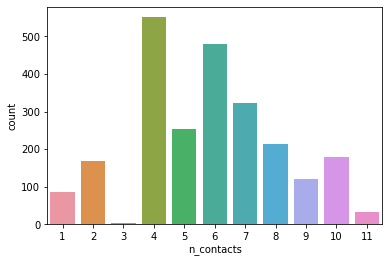

In [794]:
sns.countplot(final_merge['n_contacts'])

<AxesSubplot:xlabel='pos', ylabel='n_contacts'>

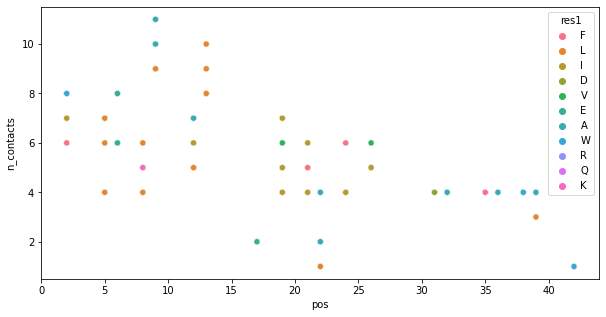

In [830]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x='pos', y='n_contacts', data=final_merge, hue='res1')

/Users/tek317/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='pos', ylabel='count'>

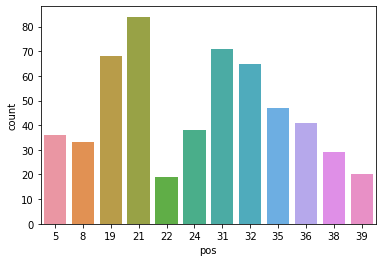

In [832]:
sns.countplot(final_merge.query('n_contacts==4')['pos'])

/Users/tek317/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='pos', ylabel='count'>

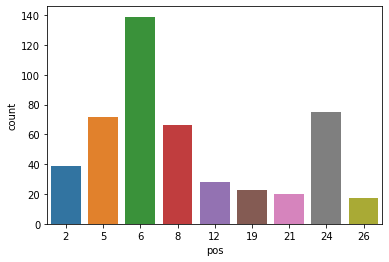

In [833]:
sns.countplot(final_merge.query('n_contacts==6')['pos'])

<AxesSubplot:xlabel='n_contacts', ylabel='change_avg_mut_stability'>

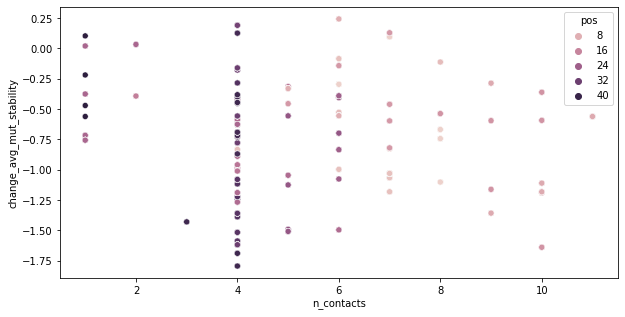

In [834]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x='n_contacts', y='change_avg_mut_stability', data=final_merge, hue='pos')

<AxesSubplot:xlabel='n_contacts', ylabel='change_avg_mut_stability'>

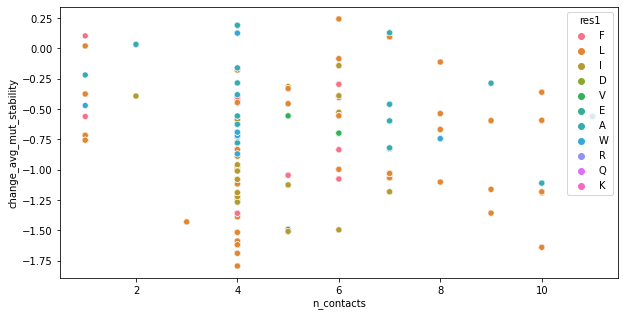

In [824]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x='n_contacts', y='change_avg_mut_stability', data=final_merge, hue='res1')

<AxesSubplot:xlabel='n_contacts', ylabel='change_avg_mut_stability'>

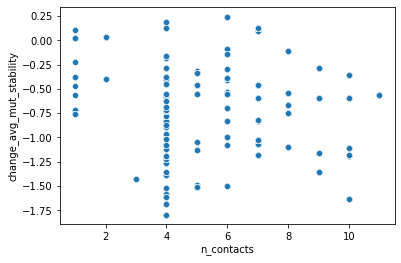

In [827]:
sns.scatterplot(x='n_contacts', y='change_avg_mut_stability', data=final_merge)

In [820]:
np.unique(final_merge['res1'])

array(['A', 'D', 'E', 'F', 'I', 'K', 'L', 'Q', 'R', 'V', 'W'],
      dtype=object)

<AxesSubplot:xlabel='pos', ylabel='n_contacts'>

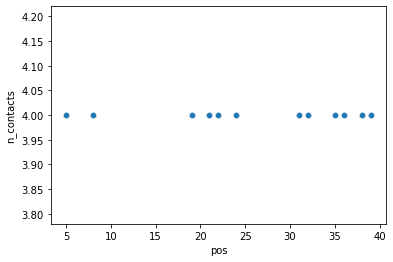

In [817]:
sns.scatterplot(x='pos', y='n_contacts', data=final_merge.query('n_contacts==4'))